<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW1_Regression_with_inference_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (pro)**

В этом домашнем задании вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;
* реализовать веб-сервис для применения построенной модели на новых данных

> Оценка за домашку = $min(\text{ваш балл}, 11)$

**Мягкий дедлайн: 27 ноября 23:59**

**Жесткий дедлайн: 20 декабря 23:59 (конец модуля)**



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from ydata_profiling import ProfileReport
import phik
import re

random.seed(42)
np.random.seed(42)

### **Задание 0**
Для чего фиксируем сиды в домашках?

`Для воспроизводимости ноубука при повторном перезапуске`

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [2]:
df_train = pd.read_csv(
    "https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv"
)
df_test = pd.read_csv(
    "https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv"
)

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [x] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [x] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [x] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [x] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла)

In [3]:
df_train.head()

name  year  selling_price  km_driven    fuel  \
0         Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1   Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
3         Maruti Swift VXI BSIII  2007         130000     120000  Petrol   
4  Hyundai Xcent 1.2 VTVT E Plus  2017         440000      45000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
3  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   
4  Individual       Manual   First Owner  20.14 kmpl  1197 CC   81.86 bhp   

                     torque  seats  
0            190Nm@ 2000rpm    5.0  
1       250Nm@ 1500-2500rpm    5.0  
2  22.4 kgm at 1750-2750rpm    5.0  
3     11.5@ 4,500(kgm@ rpm)    5.0  
4         113.75nm@ 4000rpm    5.0

Колонки с дубликатами:

In [4]:
df_train.isnull().sum()[df_train.isnull().sum() > 0]

mileage      202
engine       202
max_power    196
torque       203
seats        202
dtype: int64

Есть полные дубликаты

In [5]:
print("кол-во дубликатов:", df_train.duplicated().sum())

кол-во дубликатов: 985


In [6]:
profile = ProfileReport(df_train, title="Profiling Report")

In [7]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- Автомобили с 2000 года
- Пробег вероятно имеет большой выброс
- переменные mileage, engine имеют текстовый формат, надо доставать числа
- цена имеет высокую корреляцию с transmission и годом
- переменная torque выглядит страшно

In [8]:
df_train = df_train.drop_duplicates()
# df_test = df_test.drop_duplicates()

### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [9]:
print("Train:")
print(df_train.select_dtypes(include=["int64", "float64"]).describe().round(3))

print("\nTest:")
print(df_test.select_dtypes(include=["int64", "float64"]).describe().round(3))

Train:
           year  selling_price    km_driven     seats
count  6014.000   6.014000e+03     6014.000  5824.000
mean   2013.447   5.219820e+05    73764.150     5.438
std       4.080   5.338426e+05    59610.747     0.992
min    1983.000   2.999900e+04        1.000     2.000
25%    2011.000   2.500000e+05    39000.000     5.000
50%    2014.000   4.099990e+05    70000.000     5.000
75%    2017.000   6.400000e+05   100000.000     5.000
max    2020.000   1.000000e+07  2360457.000    14.000

Test:
           year  selling_price   km_driven    seats
count  1000.000       1000.000    1000.000  981.000
mean   2013.681     617901.042   71393.341    5.411
std       4.012     758553.861   48486.219    0.920
min    1995.000      31000.000    1303.000    4.000
25%    2011.000     250000.000   37000.000    5.000
50%    2014.000     434999.000   61500.000    5.000
75%    2017.000     670000.000  100000.000    5.000
max    2020.000    6000000.000  375000.000    9.000


In [10]:
print("Train:")
print(df_train.select_dtypes(include=["object"]).describe())
print("\nTest:")
print(df_test.select_dtypes(include=["object"]).describe())

Train:
                          name    fuel seller_type transmission        owner  \
count                     6014    6014        6014         6014         6014   
unique                    1924       4           3            2            5   
top     Maruti Swift Dzire VDI  Diesel  Individual       Manual  First Owner   
freq                       107    3269        5394         5505         3721   

          mileage   engine max_power          torque  
count        5824     5824      5827            5823  
unique        386      120       316             419  
top     18.9 kmpl  1248 CC    74 bhp  190Nm@ 2000rpm  
freq          184      795       282             417  

Test:
                       name    fuel seller_type transmission        owner  \
count                  1000    1000        1000         1000         1000   
unique                  621       4           3            2            5   
top     Maruti Alto 800 LXI  Diesel  Individual       Manual  First Owner   
fr

In [11]:
for column in df_train.select_dtypes(include=["int64", "float64"]).columns:
    print(f"\nColumn: {column}")
    print(f"Train mean: {df_train[column].mean():.2f}")
    print(f"Train median: {df_train[column].median():.2f}")
    print(f"Test mean: {df_test[column].mean():.2f}")
    print(f"Test median: {df_test[column].median():.2f}")


Column: year
Train mean: 2013.45
Train median: 2014.00
Test mean: 2013.68
Test median: 2014.00

Column: selling_price
Train mean: 521982.03
Train median: 409999.00
Test mean: 617901.04
Test median: 434999.00

Column: km_driven
Train mean: 73764.15
Train median: 70000.00
Test mean: 71393.34
Test median: 61500.00

Column: seats
Train mean: 5.44
Train median: 5.00
Test mean: 5.41
Test median: 5.00


разница в цене между train/test (2.5%)

In [12]:
409999.00 / 420000.00

0.9761880952380952

пробег (7%)

In [13]:
65000.00 / 70000.00

0.9285714285714286

В тесте чуть более дорогие автомобили и меньше пробег (а цена отрицательно связана с пробегом, поэтому тут логично), но в целом распределения достаточно схожи между train/test

### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.05 балла)
- [ ] Отобразите такие объекты (0.05 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.05 балла)
- [ ] Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.05 балла)

In [14]:
features = df_train.columns.tolist()
features.remove("selling_price")
duplicates = df_train[df_train.duplicated(subset=features, keep=False)]
len(duplicates)

338

In [15]:
duplicates.sort_values(by=features)

name  year  selling_price  km_driven  \
124            BMW X4 M Sport X xDrive20d  2019        5800000       7500   
370            BMW X4 M Sport X xDrive20d  2019        5400000       7500   
447              Chevrolet Beat Diesel LT  2012         220000      70000   
766              Chevrolet Beat Diesel LT  2012         200000      70000   
4704             Chevrolet Beat Diesel LT  2012         165000      70000   
...                                   ...   ...            ...        ...   
5262  Volkswagen Polo 1.2 MPI Comfortline  2016         395000      40000   
5263  Volkswagen Polo 1.2 MPI Comfortline  2016         385000      40000   
467      Volkswagen Vento Diesel Highline  2012         450000      90000   
2244     Volkswagen Vento Diesel Highline  2012         375000      90000   
2501     Volkswagen Vento Diesel Highline  2012         361000      90000   

        fuel seller_type transmission         owner     mileage   engine  \
124   Diesel      Dealer    Automatic   First Owner  16.78 kmpl  1995 CC   
370   Diesel      Dealer    Automatic   First Owner  16.78 kmpl  1995 CC   
447   Diesel  Individual       Manual  Second Owner  25.44 kmpl   936 CC   
766   Diesel  Individual       Manual  Second Owner  25.44 kmpl   936 CC   
4704  Diesel  Individual       Manual  Second Owner  25.44 kmpl   936 CC   
...      ...         ...          ...           ...         ...      ...   
5262  Petrol  Individual       Manual  Second Owner   16.2 kmpl  1199 CC   
5263  Petrol  Individual       Manual  Second Owner   16.2 kmpl  1199 CC   
467   Diesel  Individual       Manual   First Owner  20.54 kmpl  1598 CC   
2244  Diesel  Individual       Manual   First Owner  20.54 kmpl  1598 CC   
2501  Diesel  Individual       Manual   First Owner  20.54 kmpl  1598 CC   

      max_power               torque  seats  
124     190 bhp  400Nm@ 1750-2500rpm    5.0  
370     190 bhp  400Nm@ 1750-2500rpm    5.0  
447    57.6 bhp       150Nm@ 1750rpm    5.0  
766    57.6 bhp       150Nm@ 1750rpm    5.0  
4704   57.6 bhp       150Nm@ 1750rpm    5.0  
...         ...                  ...    ...  
5262     74 bhp  110Nm@ 3000-4300rpm    5.0  
5263     74 bhp  110Nm@ 3000-4300rpm    5.0  
467   103.6 bhp  250Nm@ 1500-2500rpm    5.0  
2244  103.6 bhp  250Nm@ 1500-2500rpm    5.0  
2501  103.6 bhp  250Nm@ 1500-2500rpm    5.0  

[338 rows x 13 columns]

In [16]:
df_train = df_train.drop_duplicates(subset=features, keep="first")

In [17]:
df_train = df_train.reset_index(drop=True)

In [18]:
df_train.shape

(5840, 13)

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [19]:
df_train["torque"]

0                  190Nm@ 2000rpm
1             250Nm@ 1500-2500rpm
2        22.4 kgm at 1750-2750rpm
3           11.5@ 4,500(kgm@ rpm)
4               113.75nm@ 4000rpm
                  ...            
5835              96.1Nm@ 3000rpm
5836                90Nm@ 3500rpm
5837             113.7Nm@ 4000rpm
5838    24@ 1,900-2,750(kgm@ rpm)
5839               190Nm@ 2000rpm
Name: torque, Length: 5840, dtype: object

In [20]:
def clean_numeric(x, pattern=r"[\d.]+"):
    if isinstance(x, str):
        match = re.search(pattern, x)
        return float(match.group()) if match else None
    return x


def clean_torque(x):
    if isinstance(x, str):
        try:
            torque_match = re.search(r"([\d.,]+)\s*(Nm|kgm)", x.lower())
            if torque_match:
                torque = float(torque_match.group(1).replace(",", ""))
                unit = torque_match.group(2)
                if unit == "kgm":
                    torque *= 9.80665
            else:
                return None, None

            rpm_match = re.search(
                r"@?\s*([\d,]+)(?:\s*-\s*([\d,]+))?\s*(?:rpm|\(rpm\))", x.lower()
            )
            if rpm_match:
                if rpm_match.group(2):
                    rpm1 = float(rpm_match.group(1).replace(",", ""))
                    rpm2 = float(rpm_match.group(2).replace(",", ""))
                    rpm = (rpm1 + rpm2) / 2
                else:
                    rpm = float(rpm_match.group(1).replace(",", ""))
            else:
                rpm = None

            return torque, rpm
        except:
            return None, None
    return None, None


def process_dataset(df):
    df = df.copy()

    df["mileage"] = df["mileage"].apply(clean_numeric)
    df["engine"] = df["engine"].apply(clean_numeric)
    df["max_power"] = df["max_power"].apply(clean_numeric)

    torque_values = df["torque"].apply(clean_torque)
    df["torque_value"] = [x[0] for x in torque_values]
    df["max_torque_rpm"] = [x[1] for x in torque_values]

    df = df.drop("torque", axis=1)
    return df


df_train = process_dataset(df_train)
df_test = process_dataset(df_test)

numeric_columns = ["mileage", "engine", "max_power", "torque_value", "max_torque_rpm"]
for col in numeric_columns:
    df_train[col] = df_train[col].astype(float)
    df_test[col] = df_test[col].astype(float)

df_train.dtypes

name               object
year                int64
selling_price       int64
km_driven           int64
fuel               object
seller_type        object
transmission       object
owner              object
mileage           float64
engine            float64
max_power         float64
seats             float64
torque_value      float64
max_torque_rpm    float64
dtype: object

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - !!! По тренировочным данным для `train` и `test`






In [21]:
numeric_columns = [
    "mileage",
    "engine",
    "max_power",
    "torque_value",
    "max_torque_rpm",
    "seats",
]
train_medians = df_train[numeric_columns].median()

df_train[numeric_columns] = df_train[numeric_columns].fillna(train_medians)
df_test[numeric_columns] = df_test[numeric_columns].fillna(train_medians)

В данных о автомобилях часто встречаются выбросы (очень дорогие или мощные автомобили) и среднее может сильно искажаться из-за таких выбросов

мы должны брать медину только из тренировочного набора, чтобы не просочились тестовые данные и мы бы на них не обучились.

In [22]:
print("train:")
print(df_train[numeric_columns].isnull().sum())
print("\ntest:")
print(df_test[numeric_columns].isnull().sum())

train:
mileage           0
engine            0
max_power         0
torque_value      0
max_torque_rpm    0
seats             0
dtype: int64

test:
mileage           0
engine            0
max_power         0
torque_value      0
max_torque_rpm    0
seats             0
dtype: int64


### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [23]:
for df in [df_train, df_test]:
    df["engine"] = df["engine"].astype(int)
    df["seats"] = df["seats"].astype(int)

df_train.dtypes

name               object
year                int64
selling_price       int64
km_driven           int64
fuel               object
seller_type        object
transmission       object
owner              object
mileage           float64
engine              int64
max_power         float64
seats               int64
torque_value      float64
max_torque_rpm    float64
dtype: object

`Количество мест в автомобиле принимает только целые значения, и этот диапазон небольшой (2-9 мест). Можно кол-во мест превратить в категорию автомобиля также.`

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [24]:
df_train.describe().round(2)

year  selling_price   km_driven  mileage   engine  max_power  \
count  5840.00        5840.00     5840.00  5840.00  5840.00    5840.00   
mean   2013.43      522960.09    73952.24    19.43  1429.45      87.91   
std       4.10      535432.00    60071.14     3.99   485.66      31.64   
min    1983.00       29999.00        1.00     0.00   624.00       0.00   
25%    2011.00      250000.00    39000.00    16.95  1197.00      68.00   
50%    2014.00      405000.00    70000.00    19.37  1248.00      81.86   
75%    2017.00      640000.00   100000.00    22.30  1498.00      99.00   
max    2020.00    10000000.00  2360457.00    42.00  3604.00     400.00   

         seats  torque_value  max_torque_rpm  
count  5840.00       5840.00         5840.00  
mean      5.43        128.96         3001.32  
std       0.98          9.23          108.11  
min       2.00         47.07         2250.00  
25%       5.00        128.47         3000.00  
50%       5.00        128.47         3000.00  
75%       5.00        128.47         3000.00  
max      14.00        379.52         4700.00

In [25]:
df_test.describe().round(2)

year  selling_price  km_driven  mileage   engine  max_power  \
count  1000.00        1000.00    1000.00  1000.00  1000.00    1000.00   
mean   2013.68      617901.04   71393.34    19.34  1454.88      90.84   
std       4.01      758553.86   48486.22     3.95   522.00      34.89   
min    1995.00       31000.00    1303.00     0.00   624.00      34.20   
25%    2011.00      250000.00   37000.00    16.55  1197.00      69.00   
50%    2014.00      434999.00   61500.00    19.37  1248.00      82.42   
75%    2017.00      670000.00  100000.00    22.30  1582.00     102.00   
max    2020.00     6000000.00  375000.00    32.26  3604.00     280.00   

         seats  torque_value  max_torque_rpm  
count  1000.00       1000.00         1000.00  
mean      5.40        129.34         2997.32  
std       0.91         10.87          104.69  
min       4.00         59.82         2000.00  
25%       5.00        128.47         3000.00  
50%       5.00        128.47         3000.00  
75%       5.00        128.47         3000.00  
max       9.00        314.79         4000.00

`если процент пропусков был небольшим, влияние на распределение должно быть минимальным. Но мы усилим пик значений, так как заполняем медианой. Поэтому есть более умные методы заполнения пропусков.`

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

In [26]:
df_train

name  year  selling_price  km_driven  \
0                Maruti Swift Dzire VDI  2014         450000     145500   
1          Skoda Rapid 1.5 TDI Ambition  2014         370000     120000   
2             Hyundai i20 Sportz Diesel  2010         225000     127000   
3                Maruti Swift VXI BSIII  2007         130000     120000   
4         Hyundai Xcent 1.2 VTVT E Plus  2017         440000      45000   
...                                 ...   ...            ...        ...   
5835            Hyundai Santro Xing GLS  2008         120000     191000   
5836  Maruti Wagon R VXI BS IV with ABS  2013         260000      50000   
5837                  Hyundai i20 Magna  2013         320000     110000   
5838              Hyundai Verna CRDi SX  2007         135000     119000   
5839             Maruti Swift Dzire ZDi  2009         382000     120000   

        fuel seller_type transmission                 owner  mileage  engine  \
0     Diesel  Individual       Manual           First Owner    23.40    1248   
1     Diesel  Individual       Manual          Second Owner    21.14    1498   
2     Diesel  Individual       Manual           First Owner    23.00    1396   
3     Petrol  Individual       Manual           First Owner    16.10    1298   
4     Petrol  Individual       Manual           First Owner    20.14    1197   
...      ...         ...          ...                   ...      ...     ...   
5835  Petrol  Individual       Manual           First Owner    17.92    1086   
5836  Petrol  Individual       Manual          Second Owner    18.90     998   
5837  Petrol  Individual       Manual           First Owner    18.50    1197   
5838  Diesel  Individual       Manual  Fourth & Above Owner    16.80    1493   
5839  Diesel  Individual       Manual           First Owner    19.30    1248   

      max_power  seats  torque_value  max_torque_rpm  
0         74.00      5    128.467115          3000.0  
1        103.52      5    128.467115          3000.0  
2         90.00      5    219.668960          2250.0  
3         88.20      5    128.467115          3000.0  
4         81.86      5    128.467115          3000.0  
...         ...    ...           ...             ...  
5835      62.10      5    128.467115          3000.0  
5836      67.10      5    128.467115          3000.0  
5837      82.85      5    128.467115          3000.0  
5838     110.00      5    128.467115          3000.0  
5839      73.90      5    128.467115          3000.0  

[5840 rows x 14 columns]

In [27]:
%matplotlib inline

<Figure size 1500x1500 with 0 Axes>

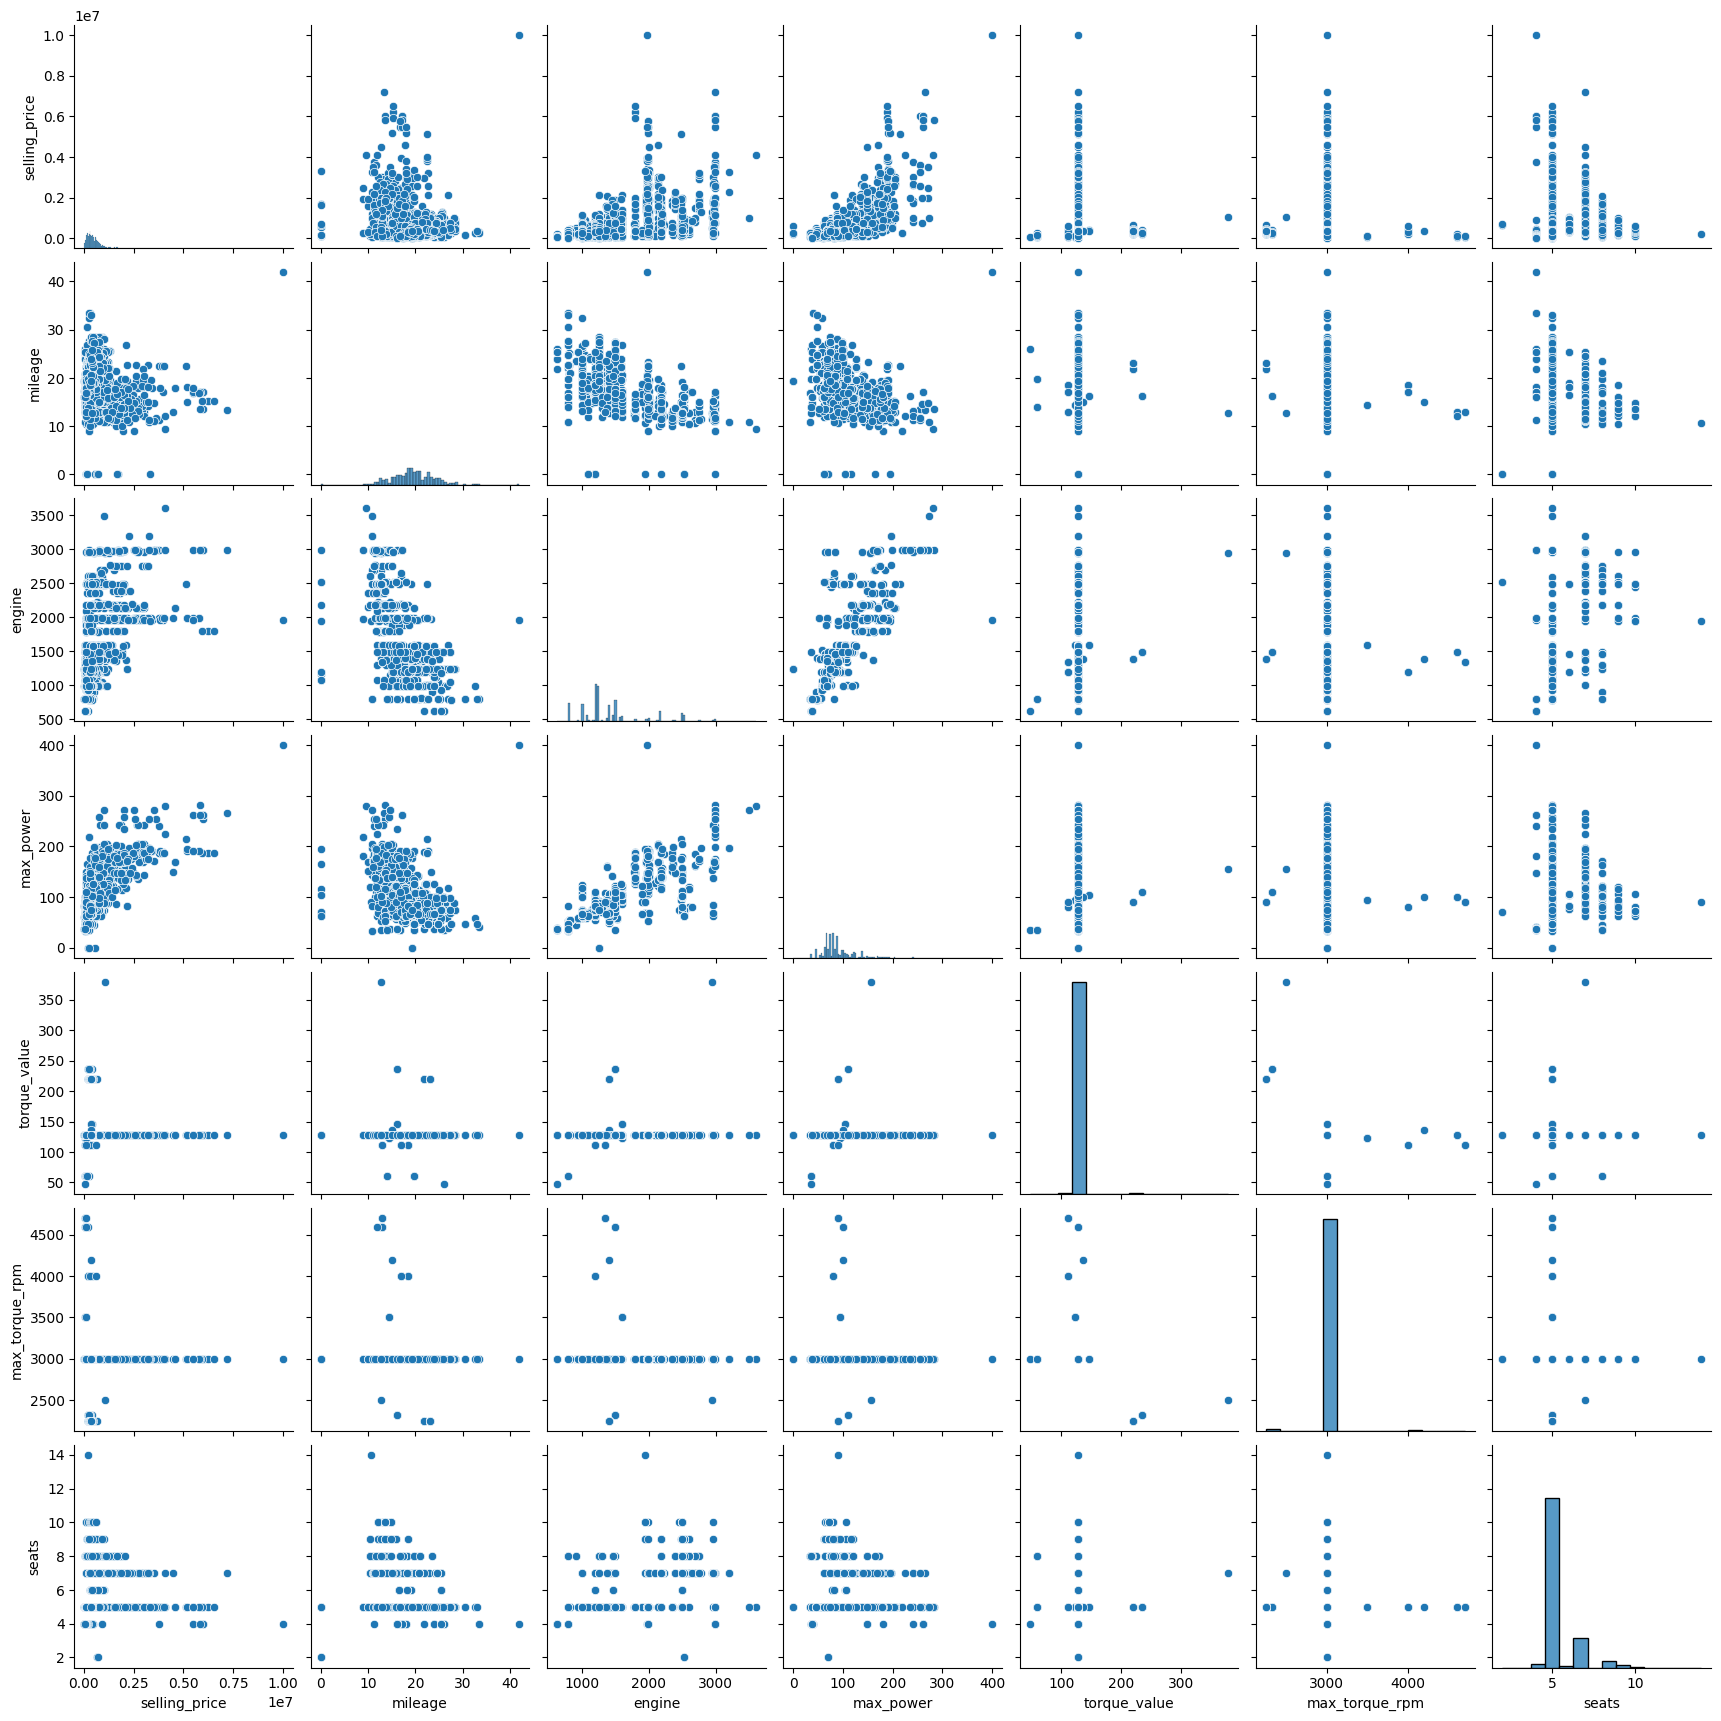

In [28]:
plt.figure(figsize=(15, 15))
sns.pairplot(
    df_train[
        [
            "selling_price",
            "mileage",
            "engine",
            "max_power",
            "torque_value",
            "max_torque_rpm",
            "seats",
        ]
    ]
)
plt.show()

<Figure size 1500x1500 with 0 Axes>

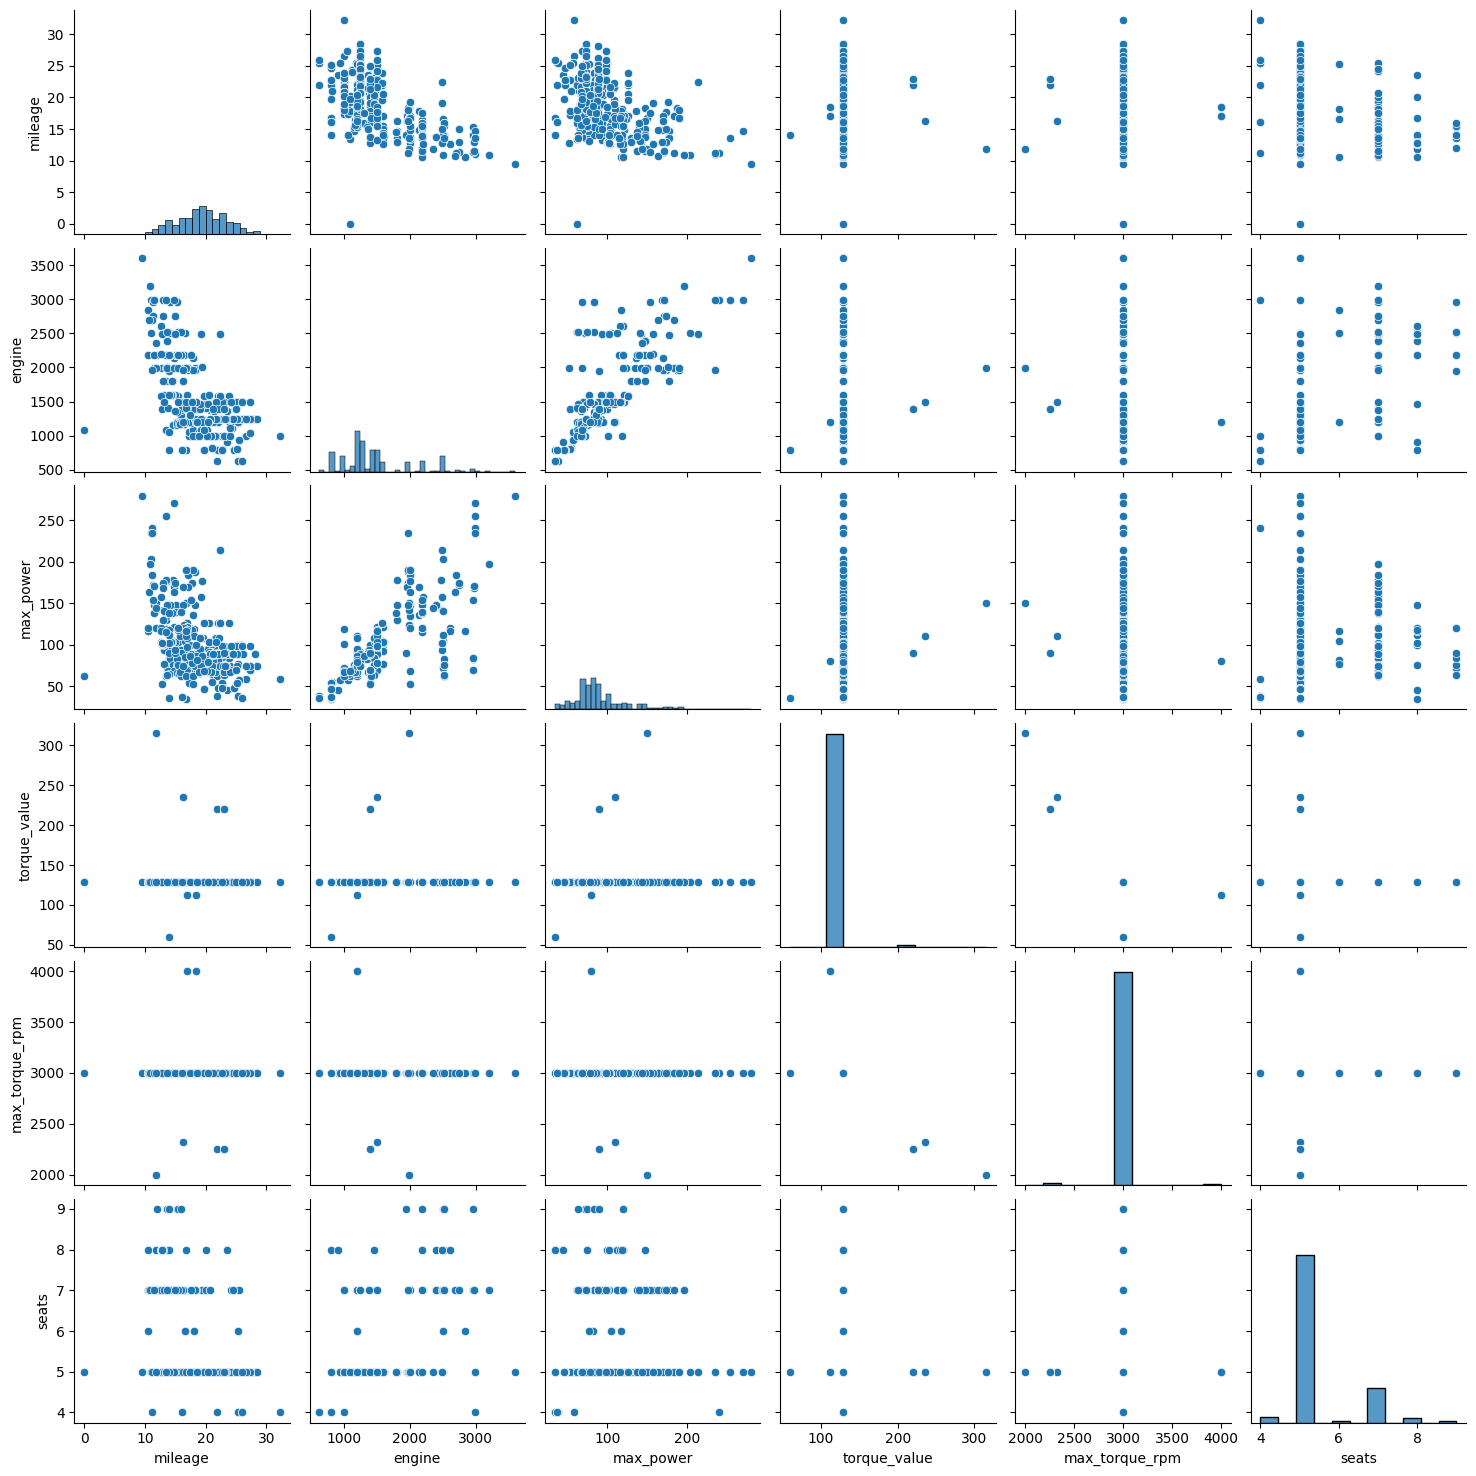

In [29]:
plt.figure(figsize=(15, 15))
sns.pairplot(
    df_test[
        ["mileage", "engine", "max_power", "torque_value", "max_torque_rpm", "seats"]
    ]
)
plt.show()

- max_power - наиболее сильная положительная связь с ценой
- engine - также заметная положительная корреляция

train/test в целом похожи по распределениям переменных

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

<Axes: >

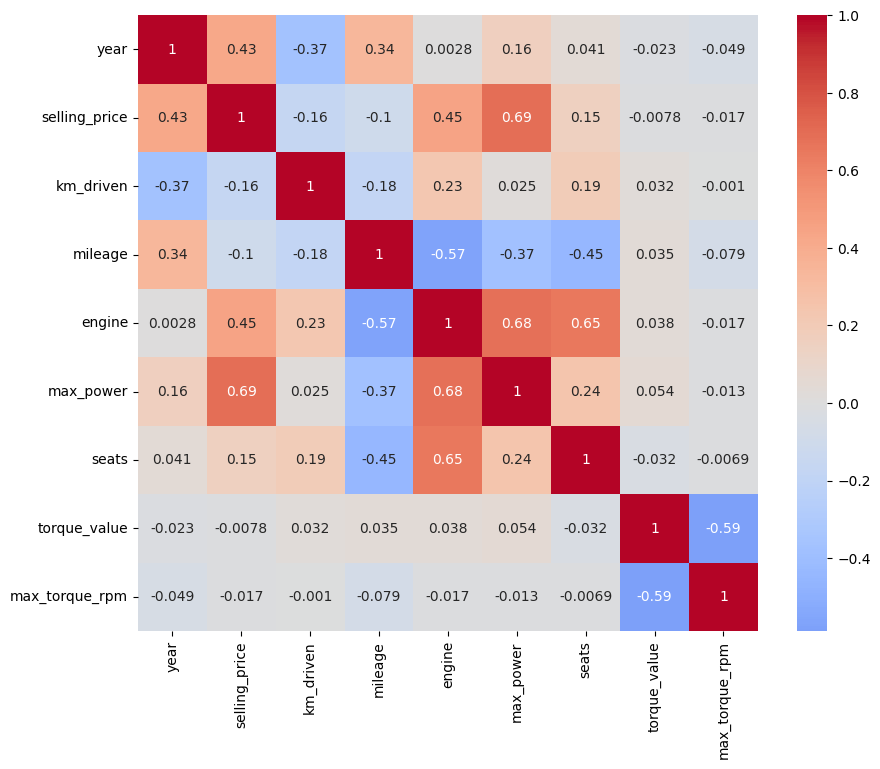

In [30]:
correlations = df_train.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap="coolwarm", center=0)

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?

- многие признаки имеют околонулевую корреляцию как torque
- сильно связаны `selling_price` и `max_power`
- неправильно, цена и кол-во километров связаны положительно

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ]

Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


In [31]:
def spearman_corr(x, y):
    x_ranks = np.argsort(np.argsort(x))
    y_ranks = np.argsort(np.argsort(y))

    n = len(x)
    x_mean = np.mean(x_ranks)
    y_mean = np.mean(y_ranks)

    numerator = np.sum((x_ranks - x_mean) * (y_ranks - y_mean))
    denominator = np.sqrt(
        np.sum((x_ranks - x_mean) ** 2) * np.sum((y_ranks - y_mean) ** 2)
    )

    return numerator / denominator


num_features = df_train.select_dtypes(include=[np.number]).columns
n = len(num_features)
manual_corr = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        manual_corr[i, j] = spearman_corr(
            df_train[num_features[i]], df_train[num_features[j]]
        )


In [32]:
numpy_spearman = df_train[num_features].corr(method="spearman")

print("custom:")
manual_corr

custom:


array([[ 1.        ,  0.7050605 , -0.56621813,  0.34295975, -0.03467668,
         0.16687537,  0.05048545,  0.01472331,  0.01288014],
       [ 0.7050605 ,  1.        , -0.29569865,  0.02616373,  0.46186566,
         0.61235243,  0.22067013, -0.00993952, -0.0218225 ],
       [-0.56621813, -0.29569865,  1.        , -0.19768735,  0.30341074,
         0.04046356,  0.10545427, -0.01848634, -0.02862025],
       [ 0.34295975,  0.02616373, -0.19768735,  1.        , -0.42898709,
        -0.30868377, -0.30722079,  0.01226403, -0.01922983],
       [-0.03467668,  0.46186566,  0.30341074, -0.42898709,  1.        ,
         0.71152631,  0.36166019,  0.0106447 , -0.01432538],
       [ 0.16687537,  0.61235243,  0.04046356, -0.30868377,  0.71152631,
         1.        ,  0.20068732, -0.00689197, -0.03383801],
       [ 0.05048545,  0.22067013,  0.10545427, -0.30722079,  0.36166019,
         0.20068732,  1.        ,  0.4909018 ,  0.50022115],
       [ 0.01472331, -0.00993952, -0.01848634,  0.01226403,  0

In [33]:
print("\nnumpy:")
numpy_spearman.round(2)


numpy:


year  selling_price  km_driven  mileage  engine  max_power  \
year            1.00           0.71      -0.57     0.35   -0.04       0.17   
selling_price   0.71           1.00      -0.30     0.03    0.46       0.61   
km_driven      -0.57          -0.30       1.00    -0.20    0.30       0.04   
mileage         0.35           0.03      -0.20     1.00   -0.43      -0.31   
engine         -0.04           0.46       0.30    -0.43    1.00       0.71   
max_power       0.17           0.61       0.04    -0.31    0.71       1.00   
seats           0.05           0.32       0.20    -0.44    0.53       0.30   
torque_value    0.00           0.03       0.03     0.07    0.07       0.08   
max_torque_rpm -0.01          -0.02      -0.02    -0.08   -0.04      -0.04   

                seats  torque_value  max_torque_rpm  
year             0.05          0.00           -0.01  
selling_price    0.32          0.03           -0.02  
km_driven        0.20          0.03           -0.02  
mileage         -0.44          0.07           -0.08  
engine           0.53          0.07           -0.04  
max_power        0.30          0.08           -0.04  
seats            1.00         -0.02            0.00  
torque_value    -0.02          1.00           -0.86  
max_torque_rpm   0.00         -0.86            1.00

не совсем совпадает, но достаточно хорошо

`когда исключаем выбросы, то по-прежнему видим сильную корреляцию цены с годом и max_power. torque довольно бесполезный из-за выбросов получился`

### **Дополнительные визуализации (бонус 0.2 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.

In [34]:
# your code here

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [35]:
numeric_features = [
    "mileage",
    "engine",
    "max_power",
    "torque_value",
    "max_torque_rpm",
    "seats",
]
X_train = df_train[numeric_features].copy()
X_test = df_test[numeric_features].copy()
y_train = df_train["selling_price"].copy()
y_test = df_test["selling_price"].copy()

In [36]:
assert X_train.shape == (5840, 6)

In [37]:
assert X_test.shape == (1000, 6)

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE

lr = LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print("Train:")
print(f"R2: {r2_score(y_train, y_train_pred):.4f}")
print(f"MSE: {MSE(y_train, y_train_pred):.4f}")

print("\nTest:")
print(f"R2: {r2_score(y_test, y_test_pred):.4f}")
print(f"MSE: {MSE(y_test, y_test_pred):.4f}")


Train:
R2: 0.5146
MSE: 139147548589.6893

Test:
R2: 0.5387
MSE: 265158721718.1668


выглядит неплохо, модель не переобучилась, и объясняет 50% дисперсии данных

### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

In [39]:
def r2_custom(y_true, y_pred):
    # среднее значение y
    y_mean = np.mean(y_true)

    # общая сумма квадратов
    # показывает общую вариацию в данных
    tss = np.sum((y_true - y_mean) ** 2)

    # остаточная сумма квадратов
    # насколько модель ошибается
    rss = np.sum((y_true - y_pred) ** 2)

    # R2 = 1 - RSS/TSS
    # объясненной дисперсии
    r2 = 1 - (rss / tss)

    return r2

In [40]:
print("\nManual R2 calculation:")
print(f"Train R2: {r2_custom(y_train, y_train_pred):.4f}")
print(f"Test R2: {r2_custom(y_test, y_test_pred):.4f}")


Manual R2 calculation:
Train R2: 0.5146
Test R2: 0.5387


`совпадает с готовой реализациепй`

### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

In [41]:
# your code here

`Your answer here`

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_scaled = LinearRegression()
lr_scaled.fit(X_train_scaled, y_train)

y_train_pred_scaled = lr_scaled.predict(X_train_scaled)
y_test_pred_scaled = lr_scaled.predict(X_test_scaled)

print("Train:")
print(f"R2: {r2_score(y_train, y_train_pred_scaled):.4f}")
print(f"MSE: {MSE(y_train, y_train_pred_scaled):.4f}")

print("\nTest:")
print(f"R2: {r2_score(y_test, y_test_pred_scaled):.4f}")
print(f"MSE: {MSE(y_test, y_test_pred_scaled):.4f}")


Train:
R2: 0.5146
MSE: 139147548589.6892

Test:
R2: 0.5387
MSE: 265158721718.1670


ничего не изменилось

### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [43]:
feature_importance = pd.DataFrame(
    {"feature": numeric_features, "importance": np.abs(lr_scaled.coef_)}
)
feature_importance = feature_importance.sort_values("importance", ascending=False)
feature_importance

feature     importance
2       max_power  391742.677696
0         mileage  113904.352249
3    torque_value   40611.577553
1          engine   29158.150335
4  max_torque_rpm   18191.043101
5           seats   15598.932878

Text(0.5, 1.0, 'Feature Importance')

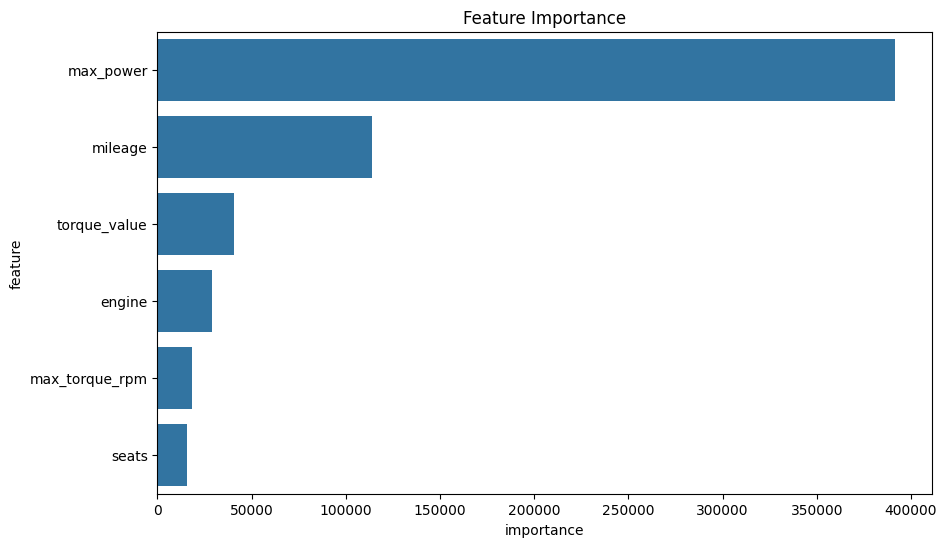

In [44]:
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feature_importance)
plt.title("Feature Importance")

самый важный - `max_power`

### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [45]:
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(X_train_scaled, y_train)

y_train_pred_lasso = lasso.predict(X_train_scaled)
y_test_pred_lasso = lasso.predict(X_test_scaled)

print("Train:")
print(f"R2: {r2_score(y_train, y_train_pred_lasso):.4f}")
print(f"MSE: {MSE(y_train, y_train_pred_lasso):.4f}")

print("\nTest:")
print(f"R2: {r2_score(y_test, y_test_pred_lasso):.4f}")
print(f"MSE: {MSE(y_test, y_test_pred_lasso):.4f}")

print("\nзанилились ли веса:")
for feat, coef in zip(numeric_features, lasso.coef_):
    print(f"{feat}: {coef:.6f}")

Train:
R2: 0.5146
MSE: 139147548601.8840

Test:
R2: 0.5387
MSE: 265159006475.6469

занилились ли веса:
mileage: 113904.111809
engine: 29162.676101
max_power: 391739.453798
torque_value: -40609.298653
max_torque_rpm: -18188.717213
seats: 15595.748369


нет, веса не занулились, вероятно потому что эти признаки важны и гиперпараметр не столь высокий, чтобы их занулить

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [46]:
from sklearn.model_selection import GridSearchCV

param_grid_lasso = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "max_iter": [1000, 3000],
    "tol": [1e-3, 1e-4],
}

lasso_grid = GridSearchCV(Lasso(), param_grid_lasso, cv=10, scoring="r2", n_jobs=-1)

lasso_grid.fit(X_train_scaled, y_train)

print("Лучшие параметры:", lasso_grid.best_params_)
print("Лучший score:", lasso_grid.best_score_)

Лучшие параметры: {'alpha': 10, 'max_iter': 1000, 'tol': 0.001}
Лучший score: 0.4751973719669998


Нет, признаки не занулились

In [47]:
np.sum(np.abs(lasso_grid.best_estimator_.coef_) < 1e-10)

np.int64(0)

In [48]:
lasso_grid.best_estimator_.coef_

array([113904.74173397,  29210.72787266, 391707.54649204, -40589.01000555,
       -18167.63753767,  15564.27417893])

`6*2*2*10 = 240 моделей`
- alpha: коэффициент регуляризации
- max_iter: максимальное число итераций
- tol: точность для критерия остановки

**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [49]:
from sklearn.linear_model import ElasticNet

param_grid_elastic = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1],
    "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
    "max_iter": [1000, 3000],
    "tol": [1e-3, 1e-4],
}

elastic_grid = GridSearchCV(
    ElasticNet(), param_grid_elastic, cv=10, scoring="r2", n_jobs=-1
)

elastic_grid.fit(X_train_scaled, y_train)

print("Лучшие параметры:", elastic_grid.best_params_)
print("Лучший score:", elastic_grid.best_score_)

Лучшие параметры: {'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 1000, 'tol': 0.0001}
Лучший score: 0.48216794882145325


`5*5*2*2*10 = 1000 моделей`

### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



In [50]:
class L0Regression:
    def __init__(self, lambda_reg=0.1, max_iter=1000):
        self.lambda_reg = lambda_reg
        self.max_iter = max_iter
        self.coef_ = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        self.coef_ = np.zeros(n_features)

        for _ in range(self.max_iter):
            coef_old = self.coef_.copy()

            for j in range(n_features):
                r = y - np.dot(X, self.coef_) + self.coef_[j] * X[:, j]

                beta = np.dot(X[:, j], r) / (np.dot(X[:, j], X[:, j]))

                if abs(beta) ** 2 * np.dot(X[:, j], X[:, j]) > 2 * self.lambda_reg:
                    self.coef_[j] = beta
                else:
                    self.coef_[j] = 0

            if np.allclose(self.coef_, coef_old):
                break

    def predict(self, X):
        return np.dot(X, self.coef_)


l0_reg = L0Regression(lambda_reg=0.1)
l0_reg.fit(X_train_scaled, y_train)

y_train_pred_l0 = l0_reg.predict(X_train_scaled)
y_test_pred_l0 = l0_reg.predict(X_test_scaled)

for feat, coef in zip(numeric_features, l0_reg.coef_):
    print(f"{feat}: {coef:.6f}")

mileage: 113904.538330
engine: 29158.637874
max_power: 391742.485059
torque_value: -40611.592300
max_torque_rpm: -18191.033330
seats: 15598.745476


Работает, результат аналогичен библиотечной реализации

# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [51]:
df_train["name"].head()

0           Maruti Swift Dzire VDI
1     Skoda Rapid 1.5 TDI Ambition
2        Hyundai i20 Sportz Diesel
3           Maruti Swift VXI BSIII
4    Hyundai Xcent 1.2 VTVT E Plus
Name: name, dtype: object

In [52]:
def extract_brand(name):
    return name.split()[0]


df_train["brand"] = df_train["name"].apply(extract_brand)
df_test["brand"] = df_test["name"].apply(extract_brand)


def extract_model(name):
    return " ".join(name.split()[1:2])


df_train["model"] = df_train["name"].apply(extract_model)
df_test["model"] = df_test["name"].apply(extract_model)

categorical_features = [
    "brand",
    "model",
    "fuel",
    "seller_type",
    "transmission",
    "owner",
]
X_train_cat = df_train[categorical_features].copy()
X_test_cat = df_test[categorical_features].copy()

print("Колво брендов:", df_train["brand"].nunique())
print(df_train["brand"].value_counts())

Колво брендов: 30
brand
Maruti           1804
Hyundai          1058
Mahindra          611
Tata              534
Toyota            309
Ford              308
Honda             308
Chevrolet         188
Renault           171
Volkswagen        153
Nissan             63
Skoda              61
Datsun             49
Mercedes-Benz      44
BMW                41
Fiat               39
Audi               31
Jeep               20
Mitsubishi          8
Volvo               8
Jaguar              7
Force               4
Isuzu               4
Land                3
MG                  3
Daewoo              3
Kia                 3
Ambassador          3
Lexus               1
Peugeot             1
Name: count, dtype: int64


In [53]:
X_train_cat.shape

(5840, 6)

In [54]:
try:
    assert X_train_cat.shape == (5840, 11)
except AssertionError:
    print(X_train_cat.shape)

(5840, 6)


In [55]:
X_train_cat.describe(include="object")

brand  model    fuel seller_type transmission        owner
count     5840   5840    5840        5840         5840         5840
unique      30    202       4           3            2            5
top     Maruti  Swift  Diesel  Individual       Manual  First Owner
freq      1804    558    3177        5223         5336         3603

### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

In [56]:
from sklearn.preprocessing import (
    OneHotEncoder,
)  # или можно использовать get_dummies из библиотеки pandas

numeric_features = [
    "year",
    "km_driven",
    "mileage",
    "engine",
    "max_power",
    "torque_value",
    "max_torque_rpm",
]
categorical_features = [
    "brand",
    "model",
    "fuel",
    "seller_type",
    "transmission",
    "owner",
    "seats",
]

ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
X_train_cat_encoded = ohe.fit_transform(X_train_cat)
X_test_cat_encoded = ohe.transform(X_test_cat)

/Users/patapon3/hse/ml-hse-hw/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


`Обучаем OHE только на train данных. Удаляем столбец, чтобы избежать идеальной мультиколлинеарности (dummy variable trap). Удалять столбец только на основании веса не стоит, так как это часть кодирования одной категориальной переменной.`

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [57]:
from sklearn.linear_model import Ridge

X_train_full = np.hstack([X_train_scaled, X_train_cat_encoded])
X_test_full = np.hstack([X_test_scaled, X_test_cat_encoded])

param_grid_ridge = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

ridge_grid = GridSearchCV(Ridge(), param_grid_ridge, cv=10, scoring="r2", n_jobs=-1)

ridge_grid.fit(X_train_full, y_train)

print("Лучшие параметры:", ridge_grid.best_params_)
print("Лучший score:", ridge_grid.best_score_)

Лучшие параметры: {'alpha': 0.1}
Лучший score: 0.7285179248743627


In [58]:
best_ridge = ridge_grid.best_estimator_
y_train_pred_ridge = best_ridge.predict(X_train_full)
y_test_pred_ridge = best_ridge.predict(X_test_full)

print("Train R2:", r2_score(y_train, y_train_pred_ridge))
print("Test R2:", r2_score(y_test, y_test_pred_ridge))

Train R2: 0.8642277133534606
Test R2: 0.8983918609615821


Стало гораздо лучше

# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 2-х баллов в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

In [59]:
# your code here

# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [60]:
def business_metrics(y_true, y_pred):
    deviation = np.abs(y_true - y_pred) / y_true
    good_predictions = np.mean(deviation <= 0.1)
    return good_predictions


print("Business metrics results:")
print("Linear regression:", business_metrics(y_test, y_test_pred_scaled))
print("Lasso:", business_metrics(y_test, y_test_pred_lasso))
print("Ridge:", business_metrics(y_test, y_test_pred_ridge))

Business metrics results:
Linear regression: 0.165
Lasso: 0.165
Ridge: 0.282


### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



In [61]:
def custom_business_metrics(y_true, y_pred):
    errors = y_true - y_pred

    penalties = np.where(
        errors > 0,
        np.abs(errors) * 1.5,
        np.abs(errors),
    )

    relative_penalties = penalties / y_true

    return -np.mean(relative_penalties)


print("\nCustom business metrics results:")
print("Linear regression:", custom_business_metrics(y_test, y_test_pred_scaled))
print("Lasso:", custom_business_metrics(y_test, y_test_pred_lasso))
print("Ridge:", custom_business_metrics(y_test, y_test_pred_ridge))


Custom business metrics results:
Linear regression: -0.792785898637417
Lasso: -0.7927845118949755
Ridge: -0.4237281023300576


# **Часть 5 (3 балла) | Реализация сервиса на FastAPI**

### **Задание 25**

Cделайте с помощью FastAPI сервис, который с точки зрения пользователя реализует две функции:

1. на вход в формате json подаются признаки одного объекта, на выходе сервис выдает предсказанную стоимость машины
2. на вход подается csv-файл с признаками тестовых объектов, на выходе получаем файл с +1 столбцом - предсказаниями на этих объектах

С точки зрения реализации это означает следующее:
- средствами pydantic должен быть описан класс базового объекта
- класс с коллецией объектов
- метод post, который получает на вход один объект описанного класса
- метод post, который получает на вход коллекцию объектов описанного класса

Шаблон для сервисной части дан ниже. Код необходимо дополнить и оформить в виде отдельного .py-файла.

In [62]:
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List

app = FastAPI()


class Item(BaseModel):
    name: str
    year: int
    selling_price: int
    km_driven: int
    fuel: str
    seller_type: str
    transmission: str
    owner: str
    mileage: str
    engine: str
    max_power: str
    torque: str
    seats: float


class Items(BaseModel):
    objects: List[Item]


@app.post("/predict_item")
def predict_item(item: Item) -> float:
    return ...


@app.post("/predict_items")
def predict_items(items: List[Item]) -> List[float]:
    return ...

Протестируйте сервис на корректность работы и приложите скриншоты (см. ниже).

# **Часть 6 (1 балл) | Оформление результатов**

### **Задание 26**

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Под результатами понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.py``-файл с реализацией сервиса
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

**Как будет выглядет проверка всего домашнего задания?**
1. Ассистент проходит по ссылке на (**открытый**) репозиторий из Энитаска
2. Смотрит ``readme.md``:
    * пожалуйста, приложите в него же скрины работы вашего сервиса -- собирать ваши проекты довольно времязатратно, но хочется убедиться, что всё работает
    * можете в md-файл приложить ссылку на screencast с демонстрацией

3. Просматривает ноутбук с DS частью
4. Заглядывает в код сервиса
5. Хвалит

# **Часть Благодарственная**

Надеемся, вы честно проделали все пункты, а не просто пролистали досюда. Потому что здесь награда за старания. Пожалуйста, не стоит награждать себя до того, как закончите работать над домашкой.

<details>
<summary><b>Что-то приятное</b></summary>

**Напоминаем, что нашем курсе действует система кото-бонусов** 🐈

На фото по ссылке — сэр кот кого-то из команды курса (преподаватель, помощник преподавателя, ассистенты).

Предлагаем вам угадать — чей это товарищ!

[Первый кот](https://ibb.co/Kz1ZRWj)

</details>